In [1]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit
from jax import random

import numpy as np

import gpx
from gpx.models import SGPR
from gpx.kernels import se_kernel

import matplotlib.pyplot as plt
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

In [2]:
def func(x):
    """Latent function."""
    return (
        1.0 * jnp.sin(x * 3 * jnp.pi)
        + 0.3 * jnp.cos(x * 9 * jnp.pi)
        + 0.5 * jnp.sin(x * 7 * jnp.pi)
    )


# Number of training examples
n = 1000

# Number of inducing variables
m = 30

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)


every = 100
X_locs = X[::every]
y_locs = y[::every]
f_locs = func(X_locs)

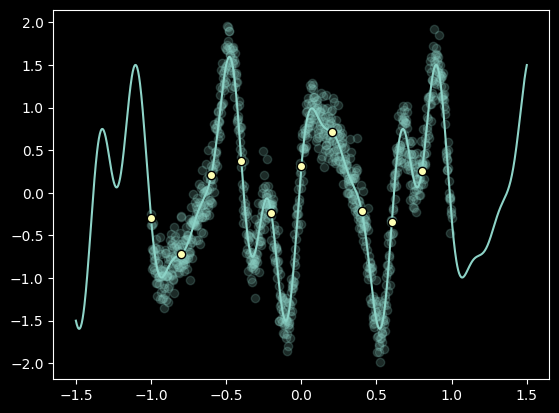

In [3]:
plt.scatter(X, y, alpha=.2)
plt.plot(X_test, f_true)
plt.scatter(X_locs, f_locs, zorder=99, ec='k')

In [4]:
kernel_params = {'lengthscale': 1.0}
sigma = 1.0

model = SGPR(X_locs, se_kernel, kernel_params, sigma, optimize_locs=False)

In [5]:
model.print()

┌────────────────────┬────────────────────────────────────────────┬─────────┬─────────┬─────────┐
│ name               │ type                                       │ dtype   │ shape   │   value │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼─────────┤
│ kernel lengthscale │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ ()      │       1 │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼─────────┤
│ sigma              │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ ()      │       1 │
└────────────────────┴────────────────────────────────────────────┴─────────┴─────────┴─────────┘


In [6]:
model.fit(X, y)

In [7]:
model.print()

┌────────────────────┬────────────────────────────────────────────┬─────────┬─────────┬──────────┐
│ name               │ type                                       │ dtype   │ shape   │    value │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼──────────┤
│ kernel lengthscale │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ ()      │ 0.262558 │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼──────────┤
│ sigma              │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ ()      │ 0.460892 │
└────────────────────┴────────────────────────────────────────────┴─────────┴─────────┴──────────┘


In [8]:
model.log_marginal_likelihood(X, y)

DeviceArray(-671.92539771, dtype=float64)

In [9]:
y_pred, cov_pred = model.predict(X_test, full_covariance=True)
err = 2 * jnp.diag(cov_pred) ** 0.5

# model prediction at input locations
y_locs_pred = model.predict(model.x_locs)

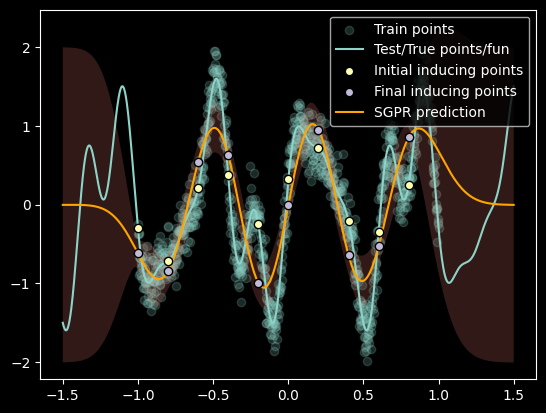

In [10]:
plt.scatter(X, y, alpha=0.2, label='Train points')
plt.plot(X_test, f_true, label='Test/True points/fun')
plt.scatter(X_locs, f_locs, zorder=99, ec='k', label='Initial inducing points')
plt.scatter(model.x_locs, y_locs_pred, ec='k', zorder=99, label='Final inducing points')
plt.plot(X_test, y_pred, c="orange", label='SGPR prediction')
plt.fill_between(
    X_test.reshape(-1), y_pred.reshape(-1) - err, y_pred.reshape(-1) + err, alpha=0.2
)
plt.legend()

Optimizing input locations

In [11]:
kernel_params = {'lengthscale': 1.0}
sigma = 1.0

model = SGPR(X_locs, se_kernel, kernel_params, sigma, optimize_locs=True)

In [12]:
model.print()

┌────────────────────┬────────────────────────────────────────────┬─────────┬─────────┬────────────────┐
│ name               │ type                                       │ dtype   │ shape   │ value          │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼────────────────┤
│ kernel lengthscale │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ ()      │ 1.             │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼────────────────┤
│ sigma              │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ ()      │ 1.             │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼────────────────┤
│ x_locs             │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ (10, 1) │ [[-1.       ]  │
│                    │                                            │         │         │  ...           │
│                    │                                 

In [13]:
model.fit(X, y)

In [14]:
model.print()

┌────────────────────┬────────────────────────────────────────────┬─────────┬─────────┬─────────────────┐
│ name               │ type                                       │ dtype   │ shape   │ value           │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼─────────────────┤
│ kernel lengthscale │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ ()      │ 0.07520542      │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼─────────────────┤
│ sigma              │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ ()      │ 0.25147541      │
├────────────────────┼────────────────────────────────────────────┼─────────┼─────────┼─────────────────┤
│ x_locs             │ <class 'jaxlib.xla_extension.DeviceArray'> │ float64 │ (10, 1) │ [[-0.92733896]  │
│                    │                                            │         │         │  ...            │
│                    │                        

In [15]:
model.log_marginal_likelihood(X, y)

DeviceArray(-73.33453743, dtype=float64)

In [16]:
y_pred, cov_pred = model.predict(X_test, full_covariance=True)
err = 2 * jnp.diag(cov_pred) ** 0.5

# model prediction at input locations
y_locs_pred = model.predict(model.params['x_locs'])

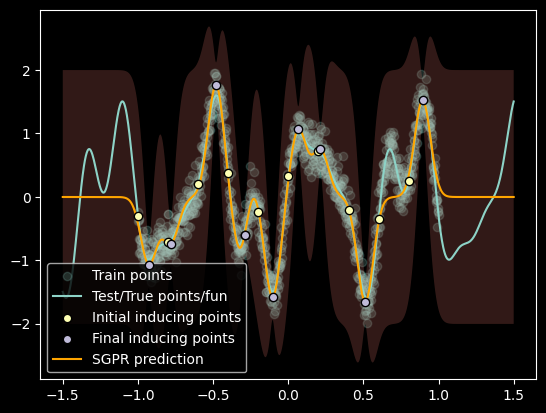

In [17]:
plt.scatter(X, y, alpha=0.2, label='Train points')
plt.plot(X_test, f_true, label='Test/True points/fun')
plt.scatter(X_locs, f_locs, zorder=99, ec='k', label='Initial inducing points')
plt.scatter(model.params['x_locs'], y_locs_pred, ec='k', zorder=99, label='Final inducing points')
plt.plot(X_test, y_pred, c="orange", label='SGPR prediction')
plt.fill_between(
    X_test.reshape(-1), y_pred.reshape(-1) - err, y_pred.reshape(-1) + err, alpha=0.2
)
plt.legend()

In [54]:
gpf_model.inducing_variable.variables[0].numpy()

array([[-1.       ],
       [-0.7997998],
       [-0.5995996],
       [-0.3993994],
       [-0.1991992],
       [ 0.001001 ],
       [ 0.2012012],
       [ 0.4014014],
       [ 0.6016016],
       [ 0.8018018]])

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value    │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ SGPR.mean_function.c     │ Parameter │ Identity         │         │ False       │ (1,)    │ float64 │ [0.]     │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1.0      │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ SGPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0      │
├──────────────────────────┼───────────┼──────────────────┼─────────┼───────────

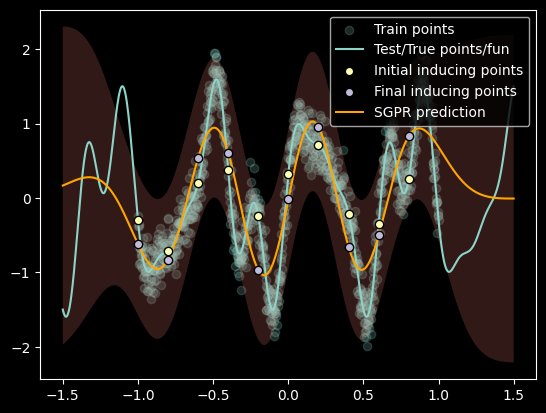

In [67]:
# Comparison with GPFlow (if available)
# Note that SGPR in GPFlow refers to Titsias (2009):
# https://proceedings.mlr.press/v5/titsias09a.html
try:
    # Without optimizing induced points
    import gpflow
    from gpflow.utilities import print_summary
    from gpflow.models import SGPR as gpf_SGPR
    from gpflow.kernels import RBF
    from gpflow.mean_functions import Constant as C
    import numpy as np
    
    gpf_model = gpf_SGPR((np.array(X), np.array(y)), kernel=RBF(), inducing_variable=np.array(X_locs), mean_function=C())
    gpflow.set_trainable(gpf_model.mean_function.c, False)
    gpflow.set_trainable(gpf_model.kernel.variance, False)
    gpflow.set_trainable(gpf_model.inducing_variable.Z, False)
    
    print_summary(gpf_model)
    
    opt = gpflow.optimizers.Scipy()
    opt.minimize(gpf_model.training_loss, gpf_model.trainable_variables)
    
    # Note that the RBF kernel of gpflow has lengthscale *= 1/np.sqrt(2)
    # Note that is also reports the likelihood variance (sigma ** 2)
    print_summary(gpf_model)
    print(-gpf_model.training_loss())
    
    plt.scatter(X, y, alpha=0.2, label='Train points')
    plt.plot(X_test, f_true, label='Test/True points/fun')
    plt.scatter(X_locs, f_locs, zorder=99, ec='k', label='Initial inducing points')
    
    y_pred, cov_pred = gpf_model.predict_y(np.array(X_test))
    y_pred_loc, _ = gpf_model.predict_y(gpf_model.inducing_variable.variables[0])
    err = 2 * cov_pred ** 0.5
    
    y_pred_loc = y_pred_loc.numpy().reshape(-1)
    y_pred = y_pred.numpy().reshape(-1)
    err = err.numpy().reshape(-1)
    
    plt.scatter(gpf_model.inducing_variable.variables[0], y_pred_loc, ec='k', zorder=99, label='Final inducing points')
    plt.plot(X_test, y_pred, c="orange", label='SGPR prediction')
    plt.fill_between(
        X_test.reshape(-1), y_pred - err, y_pred + err, alpha=0.2
    )
    plt.legend()


except ModuleNotFoundError:
    pass

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value    │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ SGPR.mean_function.c     │ Parameter │ Identity         │         │ False       │ (1,)    │ float64 │ [0.]     │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ SGPR.kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 1.0      │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ SGPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0      │
├──────────────────────────┼───────────┼──────────────────┼─────────┼───────────

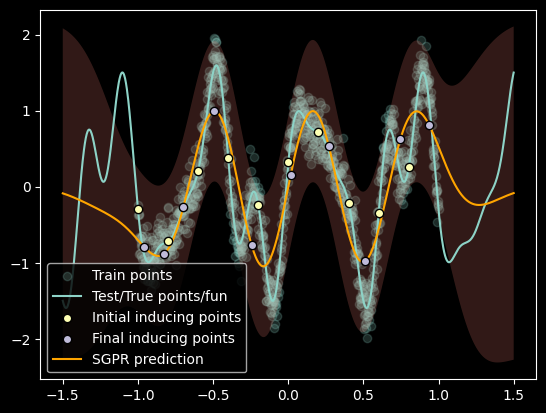

In [66]:
# Comparison with GPFlow (if available)
# Note that SGPR in GPFlow refers to Titsias (2009):
# https://proceedings.mlr.press/v5/titsias09a.html
try:
    # Optimizing inducing points
    import gpflow
    from gpflow.utilities import print_summary
    from gpflow.models import SGPR as gpf_SGPR
    from gpflow.kernels import RBF
    from gpflow.mean_functions import Constant as C
    import numpy as np
    
    gpf_model = gpf_SGPR((np.array(X), np.array(y)), kernel=RBF(), inducing_variable=np.array(X_locs), mean_function=C())
    gpflow.set_trainable(gpf_model.mean_function.c, False)
    gpflow.set_trainable(gpf_model.kernel.variance, False)
    #gpflow.set_trainable(gpf_model.inducing_variable.Z, False)
    
    print_summary(gpf_model)
    
    opt = gpflow.optimizers.Scipy()
    opt.minimize(gpf_model.training_loss, gpf_model.trainable_variables)
    
    # Note that the RBF kernel of gpflow has lengthscale *= 1/np.sqrt(2)
    # Note that is also reports the likelihood variance (sigma ** 2)
    print_summary(gpf_model)
    print(-gpf_model.training_loss())
    
    plt.scatter(X, y, alpha=0.2, label='Train points')
    plt.plot(X_test, f_true, label='Test/True points/fun')
    plt.scatter(X_locs, f_locs, zorder=99, ec='k', label='Initial inducing points')
    
    y_pred, cov_pred = gpf_model.predict_y(np.array(X_test))
    y_pred_loc, _ = gpf_model.predict_y(gpf_model.inducing_variable.variables[0])
    err = 2 * cov_pred ** 0.5
    
    y_pred_loc = y_pred_loc.numpy().reshape(-1)
    y_pred = y_pred.numpy().reshape(-1)
    err = err.numpy().reshape(-1)
    
    plt.scatter(gpf_model.inducing_variable.variables[0], y_pred_loc, ec='k', zorder=99, label='Final inducing points')
    plt.plot(X_test, y_pred, c="orange", label='SGPR prediction')
    plt.fill_between(
        X_test.reshape(-1), y_pred - err, y_pred + err, alpha=0.2
    )
    plt.legend()

except ModuleNotFoundError:
    pass